In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

In [3]:
path = "/content/drive/Shareddrives/CNN/"

In [4]:
x=np.load(path+"load_image/new_X.npy")

# Model

In [5]:
## for Model definition/training
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from keras.optimizers import Adam

from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA

In [6]:
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_base_network(image_input_shape, embedding_size):
    input_tensor = Input(shape=image_input_shape, name="input")

    model = ResNet50(weights='imagenet', include_top= False , 
                input_tensor=input_tensor,
                input_shape=None,)
    
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(embedding_size)(x)

    base_network = Model(inputs=input_tensor, outputs=x)
    return base_network

In [7]:
from sklearn.model_selection import train_test_split
if __name__ == "__main__":
    # in case this scriot is called from another file, let's make sure it doesn't start training the network...

    batch_size = 30
    epochs = 10
    train_flag = False  # either     True or False
    embedding_size = 128
    no_of_components = 2  # for visualization -> PCA.fit_transform()

    step = 10

    # The data, split between train and test sets
    
    # x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

    input_image_shape = x[0].shape

In [8]:
# Network training...
if train_flag == True:
    base_network = create_base_network(input_image_shape, embedding_size)

    input_images = Input(shape=input_image_shape, name='input_image') # input layer for images
    input_labels = Input(shape=(1,), name='input_label')    # input layer for labels
    embeddings = base_network([input_images])               # output of network -> embeddings
    labels_plus_embeddings = concatenate([input_labels, embeddings])  # concatenating the labels + embeddings

    # Defining a model with inputs (images, labels) and outputs (labels_plus_embeddings)
    model = Model(inputs=[input_images, input_labels],
                  outputs=labels_plus_embeddings)

    model.summary()

    # train session
    opt = Adam(lr=0.00001)  # choose optimiser. RMS is good too!

    model.compile(loss=triplet_loss_adapted_from_tf,
                  optimizer=opt)

    filepath = "semiH_trip_MNIST_v13_ep{epoch:02d}_BS%d.hdf5"% batch_size
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, period=25)
    callbacks_list = [checkpoint]
    """
    #Train the model using generator vs using the full batch
    H = model.fit(
    generator(x_train, y_train, batch_size),
    epochs=epochs,
    steps_per_epoch = x.shape[0]/batch_size,
    validation_data = generator(x_test[:500,:,:,:], y_test[:500], batch_size*2),
    validation_steps = x.shape[0]/batch_size*2,
    callbacks=callbacks_list
    )
    
        
    plt.figure(figsize=(8,8))
    plt.plot(H.history['loss'], label='training loss')
    plt.plot(H.history['val_loss'], label='validation loss')
    plt.legend()
    plt.title('Train/validation loss')
    plt.show()
    """
else:

        #####
    model = load_model(path+'1_2_3.h5', compile=False)  

# Prediction

In [9]:
def get_embedding(model, x):
    # Reshape
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = (x/255).astype('float32')
    return model.predict(x).reshape(-1)

def predict(x,model):
  predict_list=[]
  #predict_list= np.array(predict_list)
  for i in range(x.shape[0]):
      predict_list.append(get_embedding(model, x[i]))

  return np.array(predict_list)

# Test the network
# creating an empty network
testing_embeddings = create_base_network(input_image_shape,embedding_size=embedding_size)

# Grabbing the weights from the trained network
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
    weights = layer_source.get_weights()
    layer_target.set_weights(weights)
    del weights

In [10]:
# x_embeddings = predict(x, testing_embeddings)  # 已經存成csv檔不需要重跑這個
# x_embeddings = pd.DataFrame(x_embeddings)
# x_embeddings.head()

In [11]:
# x_embeddings.to_csv(path+"csv_files/embeddings_after.csv")

In [12]:
x_embeddings = pd.read_csv(path+"csv_files/embeddings_after.csv", encoding="unicode_escape") 

In [13]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(x_embeddings, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.33151473, 0.20332482, 0.94706563],
       [0.33151473, 1.        , 0.40989903, 0.30418439],
       [0.20332482, 0.40989903, 1.        , 0.21458127],
       [0.94706563, 0.30418439, 0.21458127, 1.        ]])

# Recommender(CNN)
* 主要商品編號(從0起算)
* 向量空間中相距近的N項商品

In [14]:
#indices = pd.Series(range(len(x_test)))
indices = pd.Series(range(len(x)))

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, top_n = 5): 
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

# get_recommender(29, top_n = 5)

## Recommendation_Plot
* 純粹畫圖

In [15]:
# def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
#     """Plot a dictionary of figures.

#     Parameters
#     ----------
#     figures : <title, figure> dictionary
#     ncols : number of columns of subplots wanted in the display
#     nrows : number of rows of subplots wanted in the figure
#     """

#     fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
#     for ind,title in enumerate(figures):
#         axeslist.ravel()[ind].imshow(cv2.cvtColor(np.array(figures[title],dtype="uint8"),cv2.COLOR_BGR2RGB))
#         axeslist.ravel()[ind].set_title(title)
#         axeslist.ravel()[ind].set_axis_off()
#     plt.tight_layout() # optional

In [16]:
# # Idx Item to Recommender
# idx_ref = 238

# # Recommendations
# idx_rec, idx_sim = get_recommender(idx_ref, top_n = 6)

# # Plot
# #===================
 
# plt.imshow(cv2.cvtColor(np.array(x[idx_ref],dtype="uint8"),cv2.COLOR_BGR2RGB))
# # plt.imshow(np.array(x_test[idx_ref]*255,dtype="uint8"))
# # generation of a dictionary of (title, images)
# # figures = {str(i): cv2.cvtColor(np.array(x[i],dtype="uint8"),cv2.COLOR_BGR2RGB) for i in idx_rec}
# figures = {str(i): x[i] for i in idx_rec}
# # figures = {str(i): np.array(x_test[i]*255,dtype="uint8") for i in idx_rec}
# # plot of the images in a figure, with 2 rows and 3 columns
# plot_figures(figures, 2, 3)

# Color Analysis

In [17]:
from collections import Counter
import math

In [18]:
# Hint: Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255].
def split_color(img, num_of_part):
    delta_h = int(180/num_of_part[0])
    delta_s = int(256/num_of_part[1])
    delta_v = int(256/num_of_part[2])
    results = {}
    h = 0
    while h in range(180):
        s = 0
        while s in range(256):
            v = 0
            while v in range(256):
                if h==0:    # 紅色需分兩段處理
                    lower = np.array([179-int((delta_h-1)/2)+1, s, v])
                    upper = np.array([179, s+delta_s-1, v+delta_v-1])
                    mask1 = cv2.inRange(img, lower, upper)

                    lower2 = np.array([h, s, v])
                    upper2 = np.array([h+int((delta_h-1)/2), s+delta_s-1, v+delta_v-1])
                    mask2 = cv2.inRange(img, lower2, upper2)

                    mask = mask1 | mask2
                else:
                    lower = np.array([h-int((delta_h-1)/2), s, v])
                    upper = np.array([h+int((delta_h-1)/2), s+delta_s-1, v+delta_v-1])
                    mask = cv2.inRange(img, lower, upper)
                results.update({(h,s,v):mask})
                v += delta_v
            s += delta_s
        h += delta_h
    # print("Slpit image into %s colors."%len(results))
    final_img = np.zeros(img.shape, dtype="uint8")
    for each_color in results:
        color_template = results[each_color]/255    # binary: 1,0
        color_template = np.array(color_template, dtype="uint8")
        color_template = cv2.cvtColor(color_template, cv2.COLOR_GRAY2RGB)*each_color    # hsv
        color_template = np.array(color_template, dtype="uint8")
        color_template = cv2.cvtColor(color_template, cv2.COLOR_HSV2RGB)    # rgb
        final_img = cv2.add(final_img, color_template)
    return final_img
    
def rgb2hex(rgb):
    hex = "#{:02x}{:02x}{:02x}".format(int(rgb[0]), int(rgb[1]), int(rgb[2]))
    return hex

def hex2rgb(hex):
    r = hex[1:3]
    g = hex[3:5]
    b = hex[5:7]
    r = int("0x"+r, 16)
    g = int("0x"+g, 16)
    b = int("0x"+b, 16)
    return [r, g, b]

def plot_image_info(img, top=5):
    # reshape the image to be a list of pixels
    img_list = img.reshape((img.shape[0]*img.shape[1], 3))
    d = {}
    for each in img_list:
        t = tuple(each)
        try:
            d[t] += 1
        except:
            d[t] = 1

    # select the 5-most frequently-appeared colors
    c = Counter(d).most_common(top)

    ordered_colors = []
    ordered_labels = []
    for each in c:
        ordered_colors.append([each[0][0]/255, each[0][1]/255, each[0][2]/255])
        ordered_labels.append(rgb2hex(each[0]))
    label_counts = [each[1] for each in c]
    
    # 印出處理後圖片及顏色分析結果
    # plt.figure(figsize=(14, 8))
    # plt.subplot(221)
    # plt.imshow(img)
    # plt.axis('off')
    
    # plt.subplot(222)
    # plt.pie(label_counts, labels=ordered_labels, colors=ordered_colors, startangle=90)
    # plt.axis('equal')
    # plt.show()
    return c

In [19]:
def color_distance(color_set_1, color_set_2):
    total_distance = 0
    total_1 = 0
    total_2 = 0
    for i in range(len(color_set_1)):
        total_1 += color_set_1[i][1]
        total_2 += color_set_2[i][1]
    for each in color_set_1:
        percentage_1 = each[1]/total_1
        # percentage_2 = 0
        r1, g1, b1 = each[0]
        # print("r1: %s, g1: %s, b1: %s" % (r1, g1, b1))
        min_distance = float("inf")
        for i in color_set_2:
            r2, g2, b2 = i[0]
            # print("r2: %s, g2: %s, b2: %s" % (r2, g2, b2))
            local_distance = math.sqrt(abs(r1-r2)**2+abs(g1-g2)**2+abs(b1-b2))
            # print("local distance: %s" % local_distance)
            if local_distance < min_distance:
                # percentage_2 = i[1]/total_2
                min_distance = local_distance
        total_distance += (min_distance * percentage_1)
        # 基於此演算法特性，採用上方方法計算總距離，下方方法相對較不適合
        # total_distance += (min_distance * percentage_1 * percentage_2)
    # print("total distance: %s" % total_distance)
    # print(color_set_2)
    return total_distance
def color_most_similar(img_1, otherImgs):
    img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2HSV)
    img_1 = split_color(img_1, (12,8,8))
    color_set_1 = plot_image_info(img_1)
    min_distance = float("inf")
    result = []
    for each in otherImgs:
        img_2 = cv2.cvtColor(otherImgs[each], cv2.COLOR_BGR2HSV)
        img_2 = split_color(img_2, (12,8,8))
        color_set_2 = plot_image_info(img_2)
        result.append([color_distance(color_set_1, color_set_2), otherImgs[each], each])
    # 由小到大排
    # result = sorted(result, key=lambda x:x[0], reverse=False)

    # 依序畫圖
    # for each in result:
    #     plt.figure(figsize=(14, 8))
    #     plt.subplot(221)
    #     plt.imshow(cv2.cvtColor(each[1], cv2.COLOR_BGR2RGB))
    return result

In [20]:
def get_color_info(idx_ref,idx_rec,df):
    figures = {str(i): x[i] for i in idx_rec}
    reorder_color = color_most_similar(x[idx_ref], figures)
    distances = []
    min_distance = float("inf")
    for each in reorder_color:
        distances.append(each[0])
        if each[0]<min_distance:
            min_distance = each[0]
    scores = []
    for each in reorder_color:
        scores.append((min_distance+1e-5)/(each[0]+1e-5))
    df["color_distance"] = distances
    df["color_score"] = scores
    return df

# Price Analysis

In [21]:
table = pd.read_csv(path+'csv_files/flipkart_processed3.csv')
def get_price(ind):
  if len(list([ind])) == 1:
    price = table['discounted_price'][ind]
    price_level = table['price_tag'][ind]
  else:
    price = table['discounted_price'][ind].values
    price_level = table['price_tag'][ind].values
  return price, price_level

In [22]:
def get_price_order(idx_ref,idx_rec):
  price_rec, price_level_rec = get_price(idx_rec)
  DF = pd.DataFrame({'Index':idx_rec,'Price':price_rec,'Price_level':price_level_rec})
  price_ref, price_level_ref = get_price(idx_ref)
  DF['Diff'] = abs(DF['Price_level'] - price_level_ref)
  DF = DF.sort_values(by=['Diff','Price'],ascending=False)
  return DF.Index, DF

In [23]:
# order, df = get_price_order(29,[28,44,39,61,55])
# get_color_info(29,list(order),df)

# Final Recommender & Visulization

In [24]:
def get_final_recommendation(idx_ref, filter=20, color_weight=1, price_weight=1, top=5):
  #get broader recommendation based on CNN
  idx_rec, idx_sim = get_recommender(idx_ref, top_n = filter)
  #get price and color analysis
  price_order, price_df = get_price_order(idx_ref,idx_rec)
  total_df = get_color_info(idx_ref, price_order, price_df)
  #design scores
#   p_score = np.linspace(0,price_weight,filter)
#   c_score = np.linspace(0,color_weight,filter)
  total_df['price_score'] = (3-total_df['Diff'])/3
#   color_df['color_score'] = c_score
#   total_df['price_score'] = p_score
  #combine two analysis
#   total_df = pd.merge(price_df,color_df,on='Index')
  total_df['total'] = total_df['price_score']*price_weight + total_df['color_score']*color_weight
  #reset order
  total_df = total_df.sort_values(by=['total'],ascending=False)
  return total_df.Index[0:top], total_df

In [25]:
def plot_figures(figures, nrows = 1, ncols=1,figsize=(20, 20)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(np.array(figures[title],dtype="uint8"),cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
        axeslist.ravel()[ind].text(0,0,'Price: '+str(table.iloc[int(title),:]['discounted_price']))
    plt.tight_layout() # optional

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars


Price:  499.0


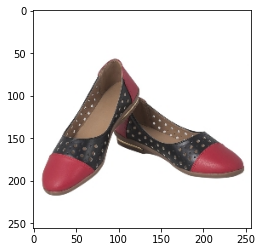

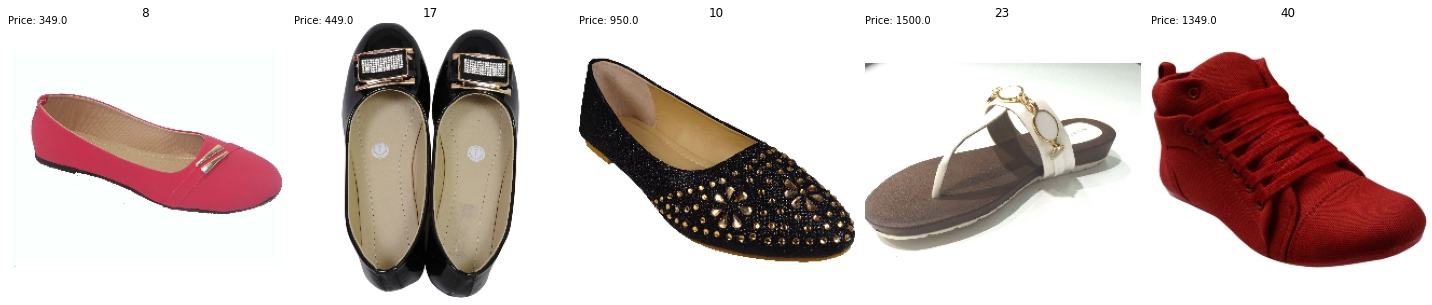

In [26]:
# Idx Item to Recommender
idx_ref = 2

# Recommendations
idx_rec, comparison = get_final_recommendation(idx_ref, filter=7, color_weight=1, price_weight=1, top=5)

# Plot 
plt.imshow(cv2.cvtColor(np.array(x[idx_ref],dtype="uint8"),cv2.COLOR_BGR2RGB))
print('Price: ',table.iloc[idx_ref,:]['discounted_price'])
# plt.imshow(np.array(x_test[idx_ref]*255,dtype="uint8"))
# generation of a dictionary of (title, images)
# figures = {str(i): cv2.cvtColor(np.array(x[i],dtype="uint8"),cv2.COLOR_BGR2RGB) for i in idx_rec}
figures = {str(i): x[i] for i in idx_rec}
# figures = {str(i): np.array(x_test[i]*255,dtype="uint8") for i in idx_rec}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 1, 5)

In [27]:
comparison

,Index,Price,Price_level,Diff,color_distance,color_score,price_score,total
8,8,349.0,1,0,7.442731,0.705662,1.000000,1.705662
17,17,449.0,1,0,9.334360,0.562658,1.000000,1.562658
10,10,950.0,2,1,7.953106,0.660377,0.666667,1.327044
23,23,1500.0,3,2,7.109294,0.738758,0.333333,1.072091
40,40,1349.0,3,2,7.802540,0.673120,0.333333,1.006454
1,1,22646.0,4,3,5.252046,1.000000,0.000000,1.000000
7,7,22646.0,4,3,6.712464,0.782432,0.000000,0.782432
